In [1]:
## from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")
import sys
sys.path.append('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong')
sys.path.append('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/deps/sparse_rrt-1')
#sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')
#sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py')
from sparse_rrt import _deep_smp_module
from tqdm.notebook import tqdm

import os

import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
from matplotlib import pyplot as plt
from sparse_rrt import _deep_smp_module, _sst_module


#[(0, 932), (1, 935), (2, 923), (8, 141), (5,931), (7, 927)]
# (5,931), (6, 286)
from mpnet.sst_envs.utils import load_data, get_obs_3d
system = "quadrotor_obs"

env_id = 5

traj_id = 913
data = load_data(system, env_id, traj_id)
print(data)
cost = data['cost'].sum()
print(cost)

obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id]
obc_list = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/sst_envs/{}_env_vox.npy'.format(system))
obc_list = obc_list[env_id].reshape(-1)

mpc_path, mpc_control, mpc_time = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/quadrotor_obs/default/paths/path_%d_%d.npy' % (env_id, traj_id),
               allow_pickle=True)        

print('env_id: ')
print(env_id)
print('traj_id:')
print(traj_id)
        

# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]

#obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

start_state = data['start_goal'][0]
goal_state = data['start_goal'][1]

{'control': array([[-1.46542789e+01, -8.93076730e-01,  5.94003872e-02,
         3.42298769e-01],
       [-1.06358859e+01,  5.32989556e-01, -4.45364695e-02,
        -5.24451132e-01],
       [-1.27809370e+01,  1.58299074e-01,  5.32523021e-01,
         1.14396350e-01],
       [-9.52740161e+00,  5.92229519e-01, -3.98492349e-01,
         5.39089826e-01],
       [-9.68667767e+00, -7.98343284e-01,  2.44426457e-01,
         7.54447859e-02],
       [-6.89554733e+00, -6.92805566e-01,  1.68564301e-02,
        -6.93987030e-01],
       [-1.18315517e+01, -5.77854037e-01,  7.19865785e-03,
         9.87834556e-01],
       [-8.23083593e+00,  8.68082696e-01, -1.34151053e-01,
        -6.76751329e-01],
       [-1.26986711e+01,  6.86856271e-01, -6.65965677e-03,
         7.11409050e-02],
       [-6.79197875e+00, -5.57383717e-01,  5.18712113e-02,
        -2.00559639e-01],
       [-7.61926716e+00,  5.95357771e-01,  1.78038908e-01,
         2.99923159e-01],
       [-6.33500898e+00, -4.99211750e-01, -2.51878217

In [2]:
params = {
    'solver_type' : "cem",
    'n_problem': 1,#128,
    'n_sample': 512,#32,g
    'n_elite': 64,#4,
    'n_t': 1,
    'max_it': 100,
    'converge_r': 1e-10,

    'dt': 2e-3,

    'mu_u': np.array([-10., 0., 0., 0.]),
    'sigma_u': np.array([15., 1., 1., 1.]),

    'mu_t': .8,
    'sigma_t': .8,
    't_max': 2.,
    'verbose': False,#True,# 
    'step_size': 0.8,

    "goal_radius": 2.0,

    "sst_delta_near": .1,
    "sst_delta_drain": 0.01,
    "goal_bias": 0.02,

    "width": 1,
    "hybrid": False,
    "hybrid_p": 0.0,

    "cost_samples": 1,
    "mpnet_weight_path":"/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/mpnet/exported/output/quadrotor_obs/mpnet-tree-batch-128.pt",
    #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v2_deep.pt",
    #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k.pt",

    # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_nonorm.pt",
    # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_subsample0.5_10k.pt",

    "cost_predictor_weight_path": "/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/mpnet/exported/output/cartpole_obs/cost_10k.pt",
    "cost_to_go_predictor_weight_path": "/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/mpnet/exported/output/cartpole_obs/cost_to_go_10k.pt",

    "refine": False,
    "using_one_step_cost": False,
    "refine_lr": 0,
    "refine_threshold": 0,
    "device_id": "cuda:3",

    "cost_reselection": False,
    "number_of_iterations": 1000,
    "weights_array": np.ones(13)

}


In [3]:
planner = _deep_smp_module.DSSTMPCWrapper(
    system_type='quadrotor_obs',
    solver_type="cem",
    start_state=data['start_goal'][0],
#             goal_state=np.array(ref_path[-1]),
    goal_state=data['start_goal'][1],
    goal_radius=params['goal_radius'],
    random_seed=0,
    sst_delta_near=params['sst_delta_near'],
    sst_delta_drain=params['sst_delta_drain'],
    obs_list=obs_list,
    width=params['width'],
    verbose=params['verbose'],
    mpnet_weight_path=params['mpnet_weight_path'], 
    cost_predictor_weight_path=params['cost_predictor_weight_path'],
    cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
    num_sample=params['cost_samples'],
    np=params['n_problem'], ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
    converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
    std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
    device_id=params['device_id'], refine_lr=params['refine_lr'],
    weights_array=params['weights_array'],
    obs_voxel_array=obc_list
)

In [4]:
system = _sst_module.Quadrotor()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)


In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_line_3d(ax, p, p_index, color='b', alpha=1):
    for p_i in p_index:
        ax.plot3D(p[p_i, 0], p[p_i, 1], p[p_i, 2], c=color, alpha=alpha)

def centered_box_to_points_3d(center, size):
    half_size = [s/2 for s in size]
    direction, p = [1, -1], []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([center[di] + [x_d, y_d, z_d][di] * half_size[0] for di in range(3)])
    return p

def rot_frame_3d(state):
    frame_size = 0.25
    b, c, d, a = state[3:7]
    rot_mat = np.array([[2 * a**2 - 1 + 2 * b**2, 2 * b * c + 2 * a * d, 2 * b * d - 2 * a * c],
                        [2 * b * c - 2 * a * d, 2 * a**2 - 1 + 2 * c**2, 2 * c * d + 2 * a * b],
                        [2 * b * d + 2 * a * c, 2 * c * d - 2 * a * b, 2 * a**2 - 1 + 2 * d**2]])
    quadrotor_frame = np.array([[frame_size, 0, 0],
                                 [0, frame_size, 0],
                                 [-frame_size, 0, 0],
                                 [0, -frame_size, 0]]).T
    quadrotor_frame = rot_mat @ quadrotor_frame + state[:3].reshape(-1, 1)
    return quadrotor_frame

def q_to_points_3d(state):
    quadrotor_frame = rot_frame_3d(state)   
    max_min, direction = [np.max(quadrotor_frame, axis=1), np.min(quadrotor_frame, axis=1)], [1, 0]
    p = []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([max_min[x_d][0], max_min[y_d][1], max_min[z_d][2]])
    return np.array(p)

def draw_box_3d(ax, p, color='b', alpha=1, face_alpha=0.1, surface_color='blue', linewidths=1, edgecolors='k'):
    index_lists = [[[0, 4], [4, 6], [6, 2], [2, 0], [0, 1], [1, 5], [5, 7], [7, 3], [3, 1], [1, 5]],
                  [[4, 5]],
                  [[6, 7]],
                  [[2, 3]]]
    for p_i in index_lists:
        draw_line_3d(ax, np.array(p), p_i, color=color, alpha=alpha)
    edges = [[p[e_i] for e_i in f_i] for f_i in [[0, 1, 5, 4],
                                                 [4, 5, 7, 6],
                                                 [6, 7, 3, 2],
                                                 [2, 0, 1, 3],
                                                 [2, 0, 4, 6],
                                                 [3, 1, 5, 7]]]
    faces = Poly3DCollection(edges, linewidths=linewidths, edgecolors=edgecolors)
    faces.set_facecolor(surface_color)
    faces.set_alpha(face_alpha)
    ax.add_collection3d(faces)

def visualize_quadrotor_path(path, draw_bbox=True, alpha=1.):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    # draw a ball of the goal region
    """
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x = 1 * np.outer(np.cos(u), np.sin(v)) * params['goal_radius']
    y = 1 * np.outer(np.sin(u), np.sin(v)) * params['goal_radius']
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v)) * params['goal_radius']
    # transport the ball to goal position
    x = x + data['start_goal'][1][0]
    y = y + data['start_goal'][1][1]
    z = z + data['start_goal'][1][2]
    ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='r', linewidth=0, alpha=0.3)
    """
    if path is not None:
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c='dodgerblue', alpha=alpha, linestyle='dotted')
        ax.plot(path[:, 0], path[:, 1], path[:, 2], c='dodgerblue', alpha=alpha, linestyle='dotted')
        ax.scatter(start_state[0], start_state[1], start_state[2], c='springgreen', s=200)
        ax.scatter(goal_state[0], goal_state[1], goal_state[2], c='red', marker='*', s=200)
        for waypoint in path:
            f = rot_frame_3d(waypoint)
            ax.scatter(f[0], f[1], f[2], color='dodgerblue', s=10)
            ax.plot(f[0,[0, 2]], f[1, [0, 2]], f[2, [0, 2]], c='dodgerblue')
            ax.plot(f[0,[1, 3]], f[1, [1, 3]], f[2, [1, 3]], c='dodgerblue')

            if draw_bbox:
                draw_box_3d(ax, q_to_points_3d(waypoint), alpha=0.1, face_alpha=0.1, color='royalblue', surface_color="royalblue", linewidths=0.)
    for obs in obs_list:
        draw_box_3d(ax, centered_box_to_points_3d(center=obs, size=[params['width']]*3),\
                    surface_color="slategray", face_alpha=1.)

    ax.set_xlim3d(-5, 5)
    ax.set_ylim3d(-5, 5)
    ax.set_zlim3d(-5, 5)
    plt.axis('off')
    ax.grid(b=None)
    return fig, ax


def propagate_path(state, control=None, time=None):
    dense_path = [state[0]]
    for i in range(len(state)-1):
        if control is None:
            solution_u, solution_t = planner.steer_solution(state[i], state[i+1])
        else:
            solution_u, solution_t = [control[i]], [time[i]]
        # proapgate
        s = state[i]
        for j in range(len(solution_u)):
            action = solution_u[j]
            num_steps = int(np.round(solution_t[j]/params['dt']))
            for k in range(num_steps):
                s = dynamics(s, action, params['dt'])
                dense_path.append(np.array(s))
                
    dense_path = np.array(dense_path)
    return dense_path[::100]

SST: env_id = 5, traj_id = 913


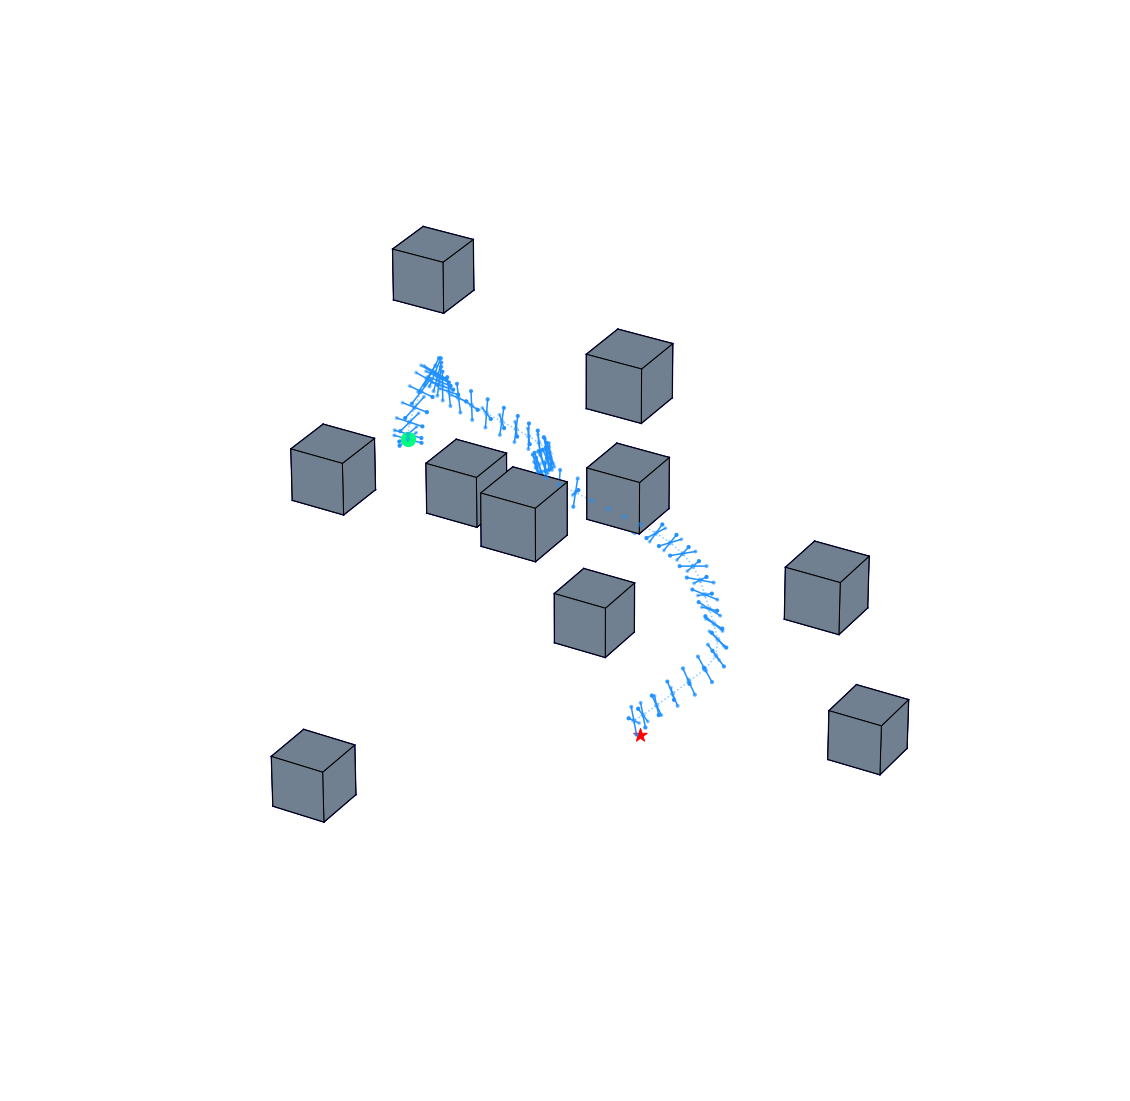

In [6]:
print('SST: env_id = %d, traj_id = %d' % (env_id, traj_id))
dense_path = propagate_path(data['path'], data['control'], data['cost'])
visualize_quadrotor_path(dense_path, False, 0.5)#,draw_bbox=False)
plt.savefig('quadrotor_sst_obs_%d_p_%d.pdf' % (env_id, traj_id), bbox_inches='tight')

MPNetTree: env_id = 5, traj_id = 913
(17, 13)
(11, 13)


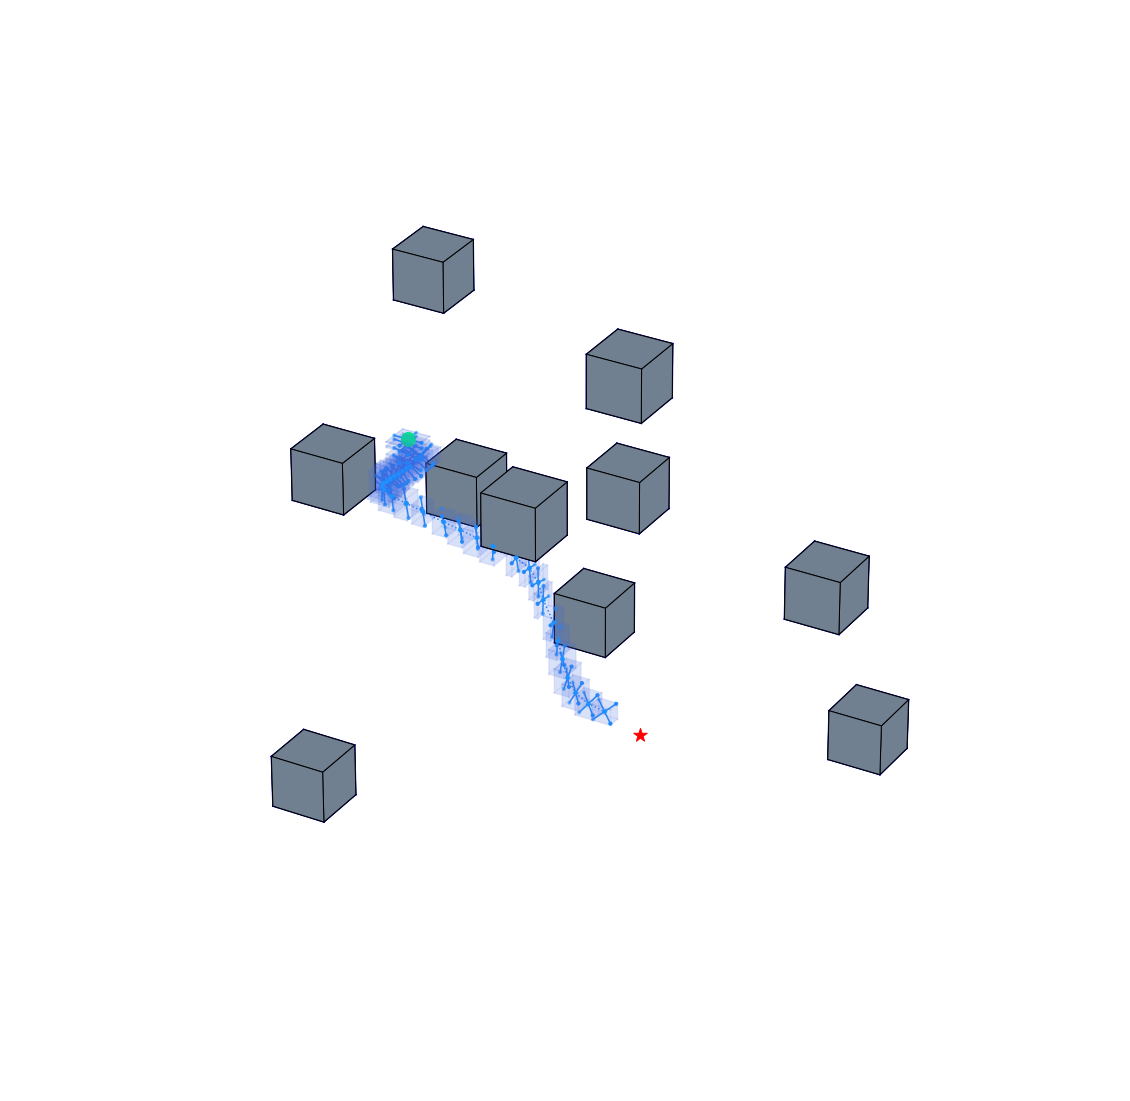

In [7]:
print('MPNetTree: env_id = %d, traj_id = %d' % (env_id, traj_id))
print(data['path'].shape)
print(mpc_path.shape)
dense_path = propagate_path(mpc_path)

visualize_quadrotor_path(dense_path)
plt.savefig('quadrotor_mpnet_obs_%d_p_%d.pdf' % (env_id, traj_id), bbox_inches='tight')